In [56]:
import re
import math
import datetime

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords

import seaborn as sns

from wordcloud import WordCloud

In [24]:
reviewFull = pd.read_csv('Reviews.csv')
reviewSampled = reviewFull.sample(frac=.5)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [25]:
# Rating function for a review. Biased towards reviews with more total views. 
#   E.g. 1 positive view out of 1 total view will not rate as high as 
#        1000 positive views out of 1200 total views.
#[CITE] https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
def lbc(posVote, totalVote):
    #Total vote to reduce calculation
    negVote = totalVote - posVote
    #Return zero if no votes o
    if(totalVote == 0):
        return 0.0
    magic = ((posVote + 1.9208) / (totalVote) - 1.96 * math.sqrt((posVote * negVote) / (totalVote) + 0.9604) / 
                (totalVote)) / (1 + 3.8416 / (totalVote))
    return magic

In [26]:
reviewSampled = reviewSampled.drop('ProfileName', axis=1)

In [27]:
df = reviewSampled

# [CITE] https://codedump.io/share/w8TDdH1LYgGt/1/format-certain-floating-dataframe-columns-into-percentage-in-pandas
nullPercents = df.isnull().sum()/df.count()
nullPercents.sort_values(inplace=True,ascending=False)
nullPercents = pd.Series([str(round(val*100, 2))+"%" for val in nullPercents], index = nullPercents.index)
nullPercents

Summary                   0.0%
Text                      0.0%
Time                      0.0%
Score                     0.0%
HelpfulnessDenominator    0.0%
HelpfulnessNumerator      0.0%
UserId                    0.0%
ProductId                 0.0%
Id                        0.0%
dtype: object

In [29]:
#Remove 2 rows where numerator > denominator. Assume this is entry error in dataset
reviewFaultyRows = reviewSampled[reviewSampled['HelpfulnessNumerator'] > reviewSampled['HelpfulnessDenominator']]
reviewSampled = reviewSampled[reviewSampled['HelpfulnessNumerator'] <= reviewSampled['HelpfulnessDenominator']]

reviewFaultyRows.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [37]:
df = reviewSampled

# Create Lbc column associated with a review that contains the lbc value for that row
df['Lbc'] = df.apply(lambda row: lbc(row['HelpfulnessNumerator'], row['HelpfulnessDenominator']), axis=1)

# Create Timestamp column associated with a review
df['Timestamp'] = pd.to_datetime(df['Time'], unit='s')

df['ReviewLength'] = df['Text'].str.len()

reviewSampled = df

In [8]:
# Creates the bag of words array
# [CITE] https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
vectorizer = CountVectorizer(lowercase = True, 
                             stop_words = 'english',
                             max_features = 1000)

bagOWord = vectorizer.fit_transform(df['Text'])
bagOWord = bagOWord.toarray()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [9]:
# Add the bag of words array to the dataframe
reviewBagOWord = pd.DataFrame(bagOWord, columns=vectorizer.vocabulary_.keys(), dtype='int16')

In [10]:
# Accumulate the sum of each of the columns into 
sumOfWords = reviewBagOWord.sum(axis = 0)

In [11]:
# Creates the vector of Tf-Idf for each word in the review
# [CITE] https://stackoverflow.com/a/37593408
frequenizer = TfidfVectorizer(lowercase = True, 
                             stop_words = 'english',
                             max_features = 1000)

Tfidf = frequenizer.fit_transform(df['Text'])
Tfidf = Tfidf.toarray()

In [12]:
# Add the Tfidf to the dataframe
reviewTfidf = pd.DataFrame(Tfidf, columns=vectorizer.vocabulary_.keys(), dtype='float32')

In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#Make matplotlib pretty
matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

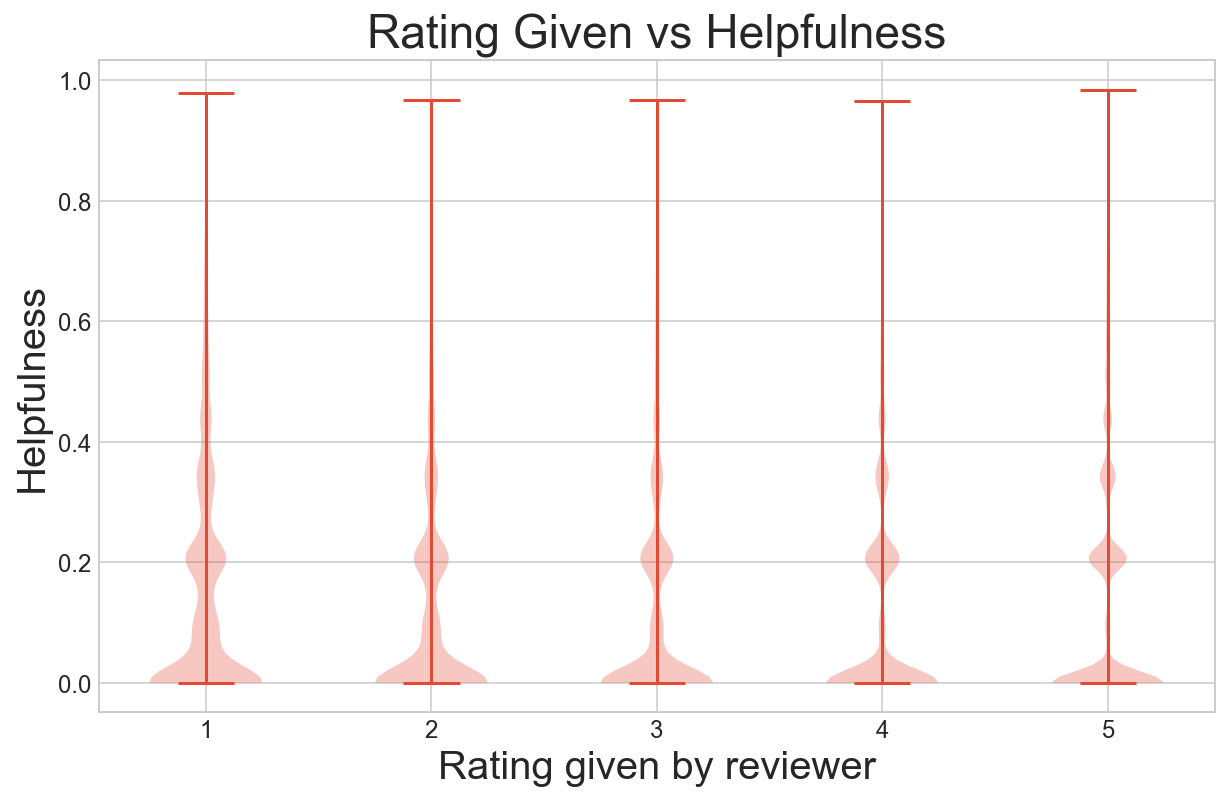

In [14]:
# Graph included entries with zero votes

df = reviewSampled

# [CITE] https://stackoverflow.com/a/43346806/3592716
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    df[df.Score == 1]['Lbc'],
    df[df.Score == 2].Lbc,
    df[df.Score == 3].Lbc,
    df[df.Score == 4].Lbc,
    df[df.Score == 5].Lbc
])
axes.set_title('Rating Given vs Helpfulness')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Rating given by reviewer')
plt.show()

In [15]:
scoreGroupSkewed = reviewSampled[reviewSampled['HelpfulnessDenominator'] != 0]

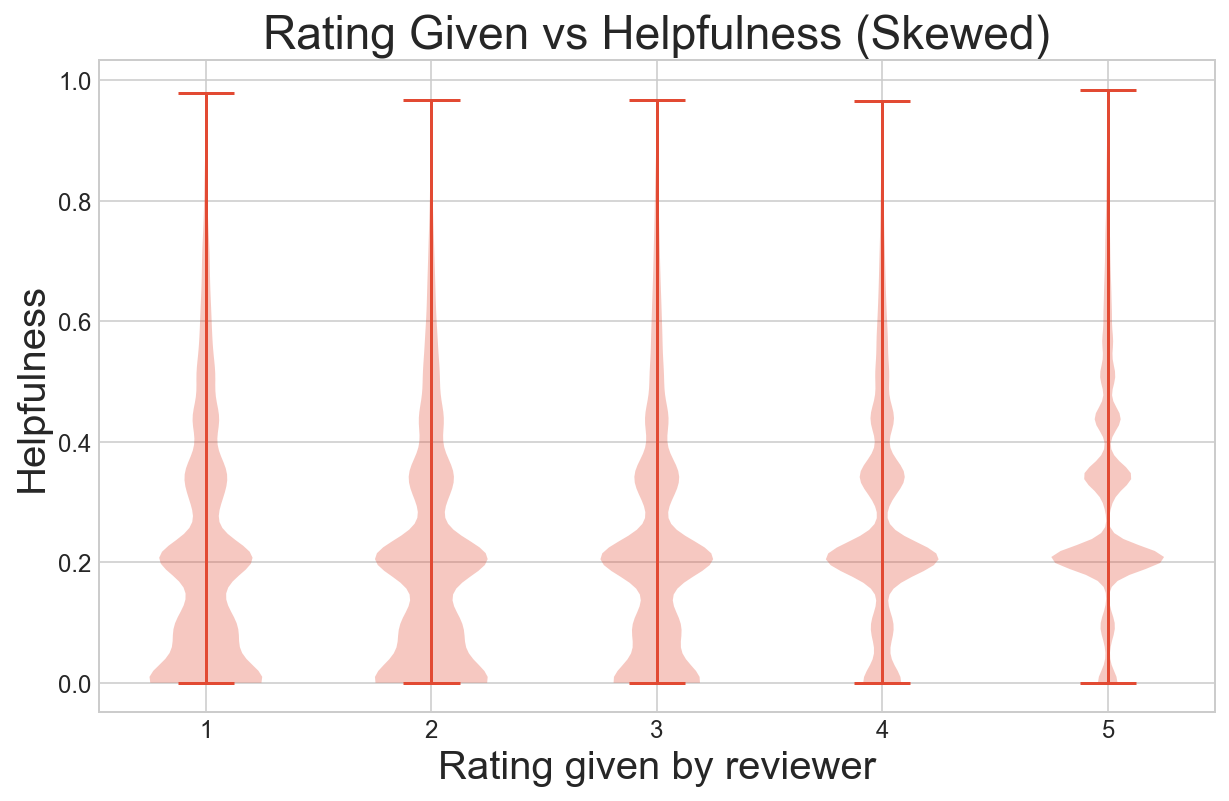

In [16]:
#As the rating the author goes up, the usefulness of the comment get better

# Graph containing only entries that have atleast 1 vote

df = scoreGroupSkewed

sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    df[df.Score == 1].Lbc,
    df[df.Score == 2].Lbc,
    df[df.Score == 3].Lbc,
    df[df.Score == 4].Lbc,
    df[df.Score == 5].Lbc
])
axes.set_title('Rating Given vs Helpfulness (Skewed)')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Rating given by reviewer')
plt.show()

In [17]:
sumOfWords = sumOfWords.sort_values(ascending=False)

sumOfWords20 = sumOfWords[0:20]
y_pos = np.arange(len(sumOfWords20))

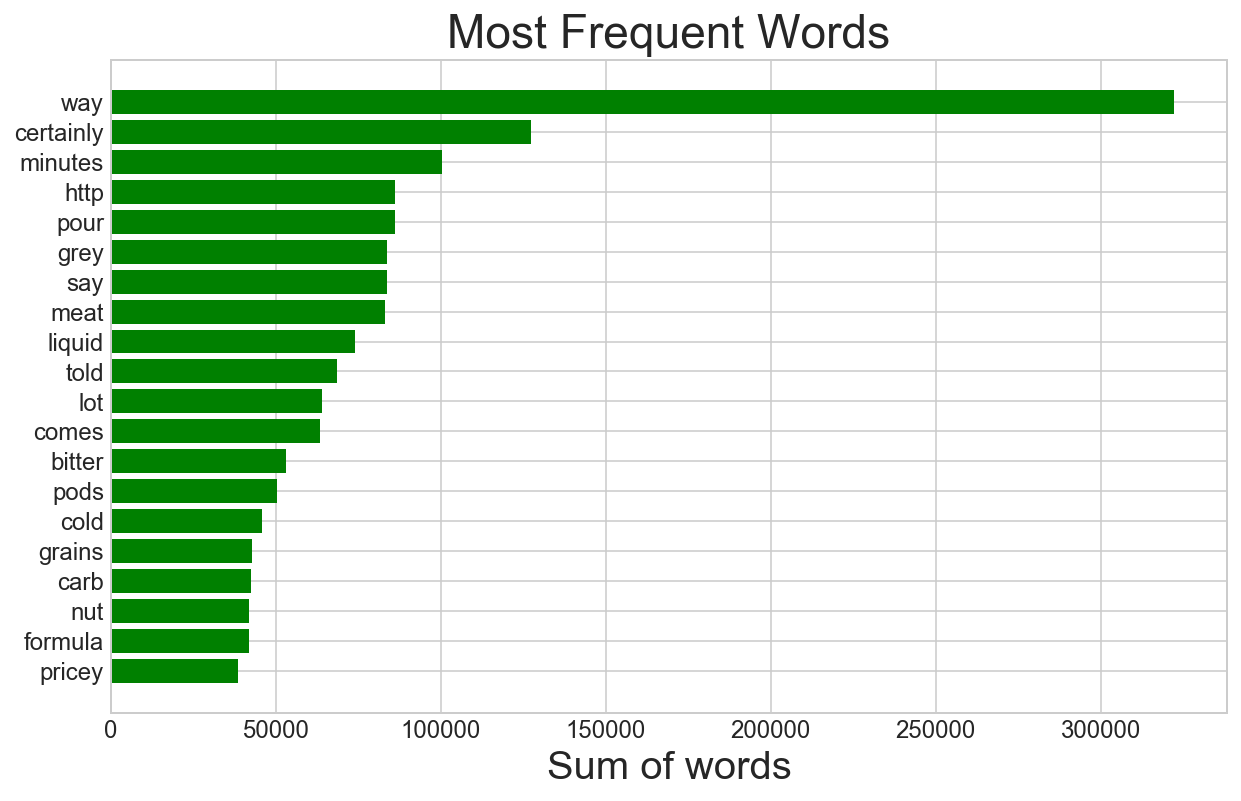

In [18]:
fig, ax = plt.subplots()

ax.barh(y_pos, sumOfWords20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(sumOfWords20.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sum of words')

ax.set_title('Most Frequent Words')

plt.show()

In [19]:
# Accumulate the sum of each of the columns into 
tfidfMean = reviewTfidf.mean(axis = 0)
tfidfMean = tfidfMean.sort_values(ascending=False)

tfidfMean20 = tfidfMean[0:20]
y_pos = np.arange(len(tfidfMean20))

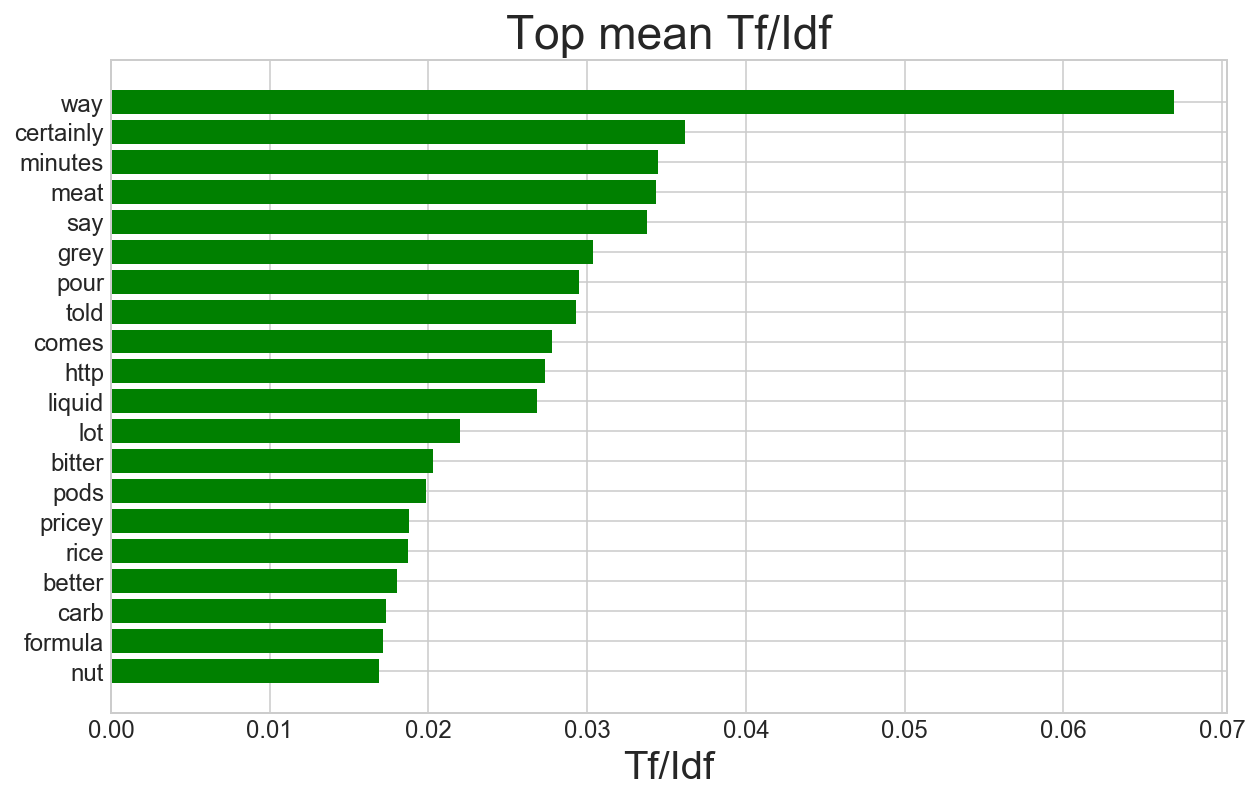

In [20]:
fig, ax = plt.subplots()

ax.barh(y_pos, tfidfMean20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(tfidfMean20.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tf/Idf')

ax.set_title('Top mean Tf/Idf')

plt.show()

In [21]:
tfidfMeanBot = tfidfMean.sort_values(ascending=True)

tfidfMeanBot20 = tfidfMeanBot[0:20]
y_pos = np.arange(len(tfidfMeanBot20))

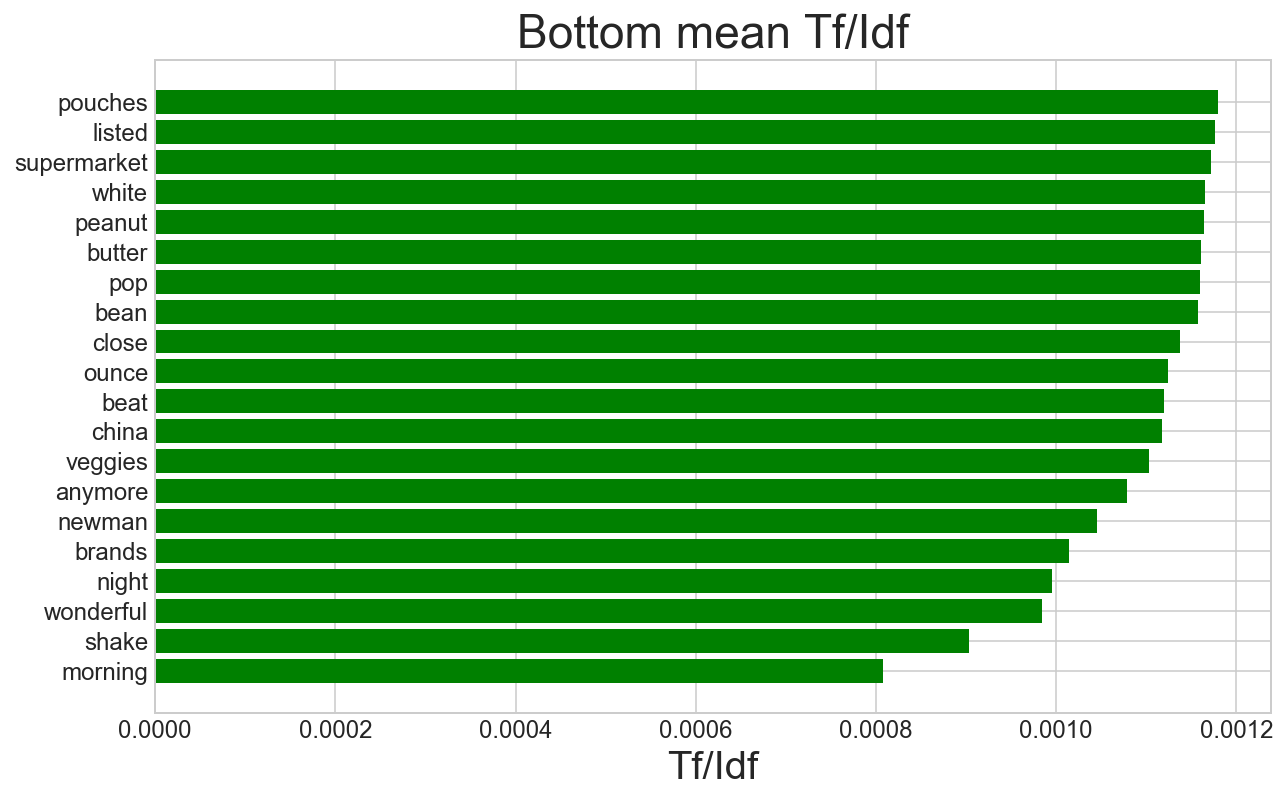

In [22]:
fig, ax = plt.subplots()

ax.barh(y_pos, tfidfMeanBot20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(tfidfMeanBot20.index)
ax.set_xlabel('Tf/Idf')

ax.set_title('Bottom mean Tf/Idf')

plt.show()

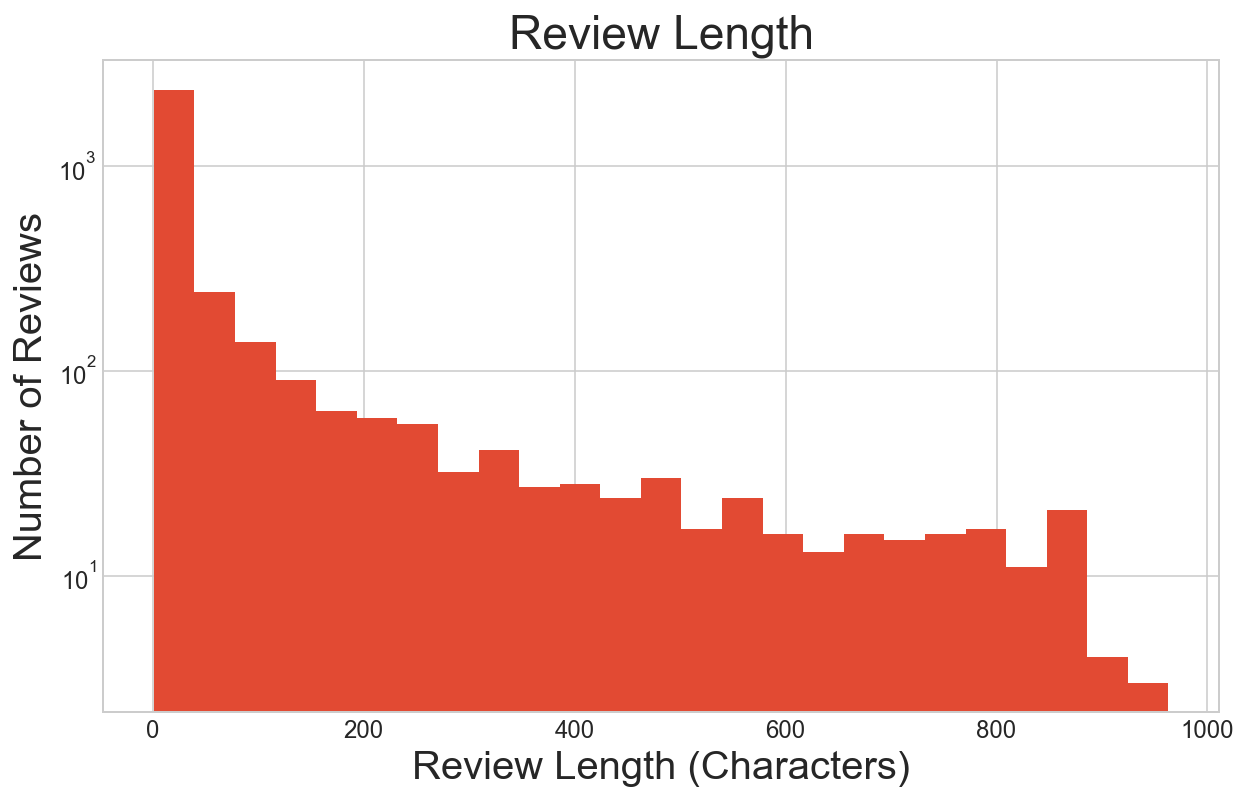

In [52]:
df = reviewSampled

plt.hist(df['ReviewLength'].value_counts(), bins=25)
plt.yscale('log')
plt.title("Review Length")
plt.ylabel('Number of Reviews')
plt.xlabel('Review Length (Characters)')
plt.show()

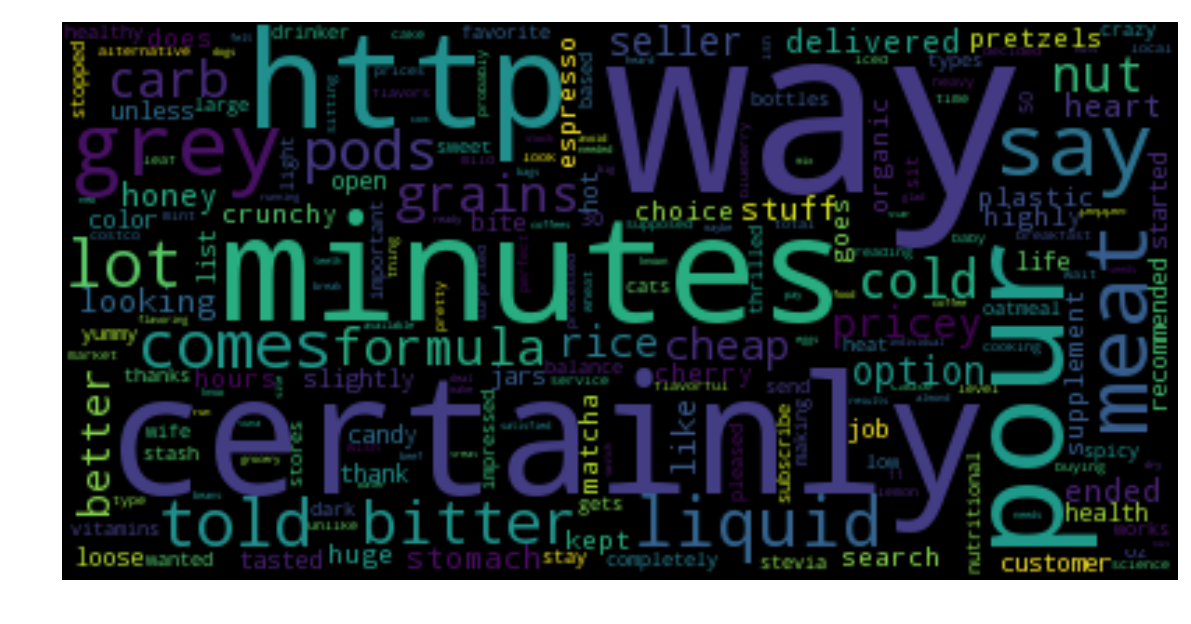

In [63]:
wc = WordCloud().generate_from_frequencies(sumOfWords)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#TODO (PAUL!!!)
# For each target class, visualize the most common relevant words and word frequencies. 
#  Are there any prevalent differences between your target classes? 
#  If you have many target classes, choose a representative subset of classes to perform this visualization. 